## Creating IWM model

In [1]:
import msprime as msp
import demes
import demesdraw

In [2]:
demo = msp.Demography()
demo.add_population(initial_size=5000, name="anc")
demo.add_population(initial_size=5000, name="P0")
demo.add_population(initial_size=5000, name="P1")
demo.set_symmetric_migration_rate(populations=("P0", "P1"), rate=0.0001)
demo.add_population_split(time=1000, derived=[f"P{i}" for i in range(2)], ancestral="anc")
g = demo.to_demes()

<Axes: ylabel='time ago (generations)'>

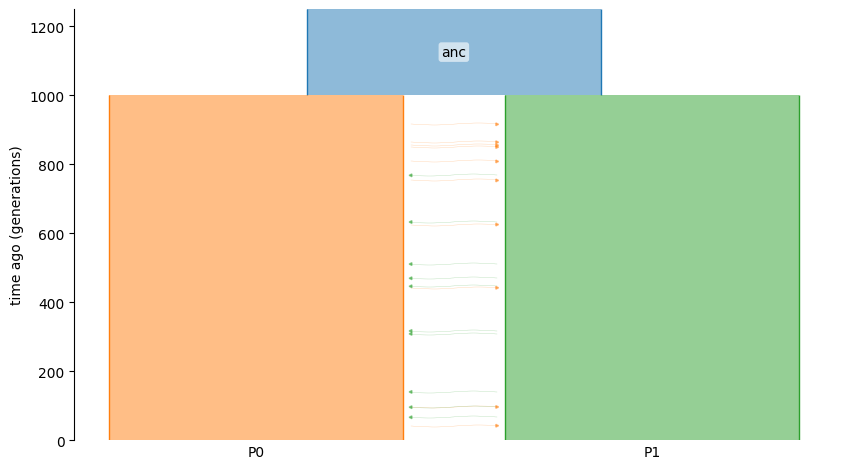

In [3]:
demesdraw.tubes(g)

## Simulating 10 diploids per population

In [4]:
sample_size = 10
samples = {f"P{i}": sample_size for i in range(2)}
anc = msp.sim_ancestry(samples=samples, demography=demo,
                       recombination_rate=1e-8,
                       sequence_length=1e8,
                       random_seed=12)
ts = msp.sim_mutations(anc, rate=1e-8, random_seed=13)

## Listing out all the variables
Please refer to Notation documentation to understand the definition of variables in demestats

In [5]:
from demestats.constr import EventTree
et = EventTree(g)
et.variables

[frozenset({('demes', 0, 'epochs', 0, 'end_size'),
            ('demes', 0, 'epochs', 0, 'start_size')}),
 frozenset({('demes', 1, 'epochs', 0, 'end_size'),
            ('demes', 1, 'epochs', 0, 'start_size')}),
 frozenset({('demes', 2, 'epochs', 0, 'end_size'),
            ('demes', 2, 'epochs', 0, 'start_size')}),
 frozenset({('demes', 1, 'proportions', 0)}),
 frozenset({('demes', 2, 'proportions', 0)}),
 frozenset({('migrations', 0, 'rate')}),
 frozenset({('migrations', 1, 'rate')}),
 frozenset({('demes', 0, 'epochs', 0, 'end_time'),
            ('demes', 1, 'start_time'),
            ('demes', 2, 'start_time'),
            ('migrations', 0, 'start_time'),
            ('migrations', 1, 'start_time')}),
 frozenset({('demes', 1, 'epochs', 0, 'end_time'),
            ('demes', 2, 'epochs', 0, 'end_time'),
            ('migrations', 0, 'end_time'),
            ('migrations', 1, 'end_time')})]

## Creating model constraints
Suppose we select the ancestral population size, the rate of migration P0 to P1, and time of divergence as the parameters of interests.

In [6]:
from demestats.constr import constraints_for
momi3_parameters = [
        frozenset({('demes', 0, 'epochs', 0, 'end_size'),
        ('demes', 0, 'epochs', 0, 'start_size')}), # Ancestral population size
        frozenset({('migrations', 0, 'rate')}), # Rate of migration
        frozenset({('demes', 0, 'epochs', 0, 'end_time'),
        ('demes', 1, 'start_time'),
        ('demes', 2, 'start_time'),
        ('migrations', 0, 'start_time'),
        ('migrations', 1, 'start_time')}) # Time of divergence
        ]
constraint = constraints_for(et, *momi3_parameters)
print(constraint)

{'eq': (array([], shape=(0, 3), dtype=float64), array([], dtype=float64)), 'ineq': (array([[-1., -0., -0.],
       [-0., -1., -0.],
       [ 0.,  1.,  0.],
       [ 0.,  0., -1.]]), array([0., 0., 1., 0.]))}


In [7]:
# If one is not familiar with frozenset objects, you can provide paths and use the `variable_for` function
# This function will achieve the same thing as the previous code chunk
parameters = [
    ('demes', 0, 'epochs', 0, 'end_size'), # The ancestral population size
    ('migrations', 0, 'rate'), # Rate of migration from P0 to P1
    ('demes', 0, 'epochs', 0, 'end_time') # Time of divergence
]

momi3_parameters = [et.variable_for(param) for param in parameters]
constraint = constraints_for(et, *momi3_parameters)
print(constraint)

{'eq': (array([], shape=(0, 3), dtype=float64), array([], dtype=float64)), 'ineq': (array([[-1., -0., -0.],
       [-0., -1., -0.],
       [ 0.,  1.,  0.],
       [ 0.,  0., -1.]]), array([0., 0., 1., 0.]))}


In [8]:
from demestats.constr import print_constraints
print_constraints(constraint, momi3_parameters)


Linear Equalities: Ax = b

None

Linear Inequalities: Ax <= b

CONSTRAINTS:
--------------------------------------------------
Row 1: -x1 <= 0
Row 2: -x2 <= 0
Row 3: x2 <= 1
Row 4: -x3 <= 0
--------------------------------------------------

AS STRINGS:
--------------------------------------------------
Row 1: -frozenset({('demes', 0, 'epochs', 0, 'end_size'), ('demes', 0, 'epochs', 0, 'start_size')}) <= 0.0
Row 2: -frozenset({('migrations', 0, 'rate')}) <= 0.0
Row 3: frozenset({('migrations', 0, 'rate')}) <= 1.0
Row 4: -frozenset({('demes', 0, 'epochs', 0, 'end_time'), ('migrations', 0, 'start_time'), ('migrations', 1, 'start_time'), ('demes', 1, 'start_time'), ('demes', 2, 'start_time')}) <= 0.0
--------------------------------------------------


## Alternative constraint representation
Please refer to the Model Constraint documentation. This alternative representation expresses inequalities with an upper and lower bound

In [9]:
from demestats.fit.util import alternative_constraint_rep

G, h = constraint["ineq"]
A_alt, ub_alt, lb_alt = alternative_constraint_rep(G, h)
print(A_alt)
print("lower bound: ", lb_alt)
print("upper bound: ", ub_alt)

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0. -0.  1.]]
lower bound:  [0. 0. 0.]
upper bound:  [inf  1. inf]


## Modifying constraints
Suppose the ancestral population size, migration rate from P0 to P1, and migration rate from P1 to P0 are the parameters of interest

In [10]:
momi3_parameters = [
    frozenset({
        ("demes", 0, "epochs", 0, "end_size"),
        ("demes", 0, "epochs", 0, "start_size"),
    }), # Ancestral population size (index 0)
    frozenset({('migrations', 0, 'rate')}), # Rate of migration P0 to P1 (index 1)
    frozenset({('migrations', 1, 'rate')}), # Rate of migration P1 to P0 (index 2)
]

constraint = constraints_for(et, *momi3_parameters)
print(constraint)

{'eq': (array([], shape=(0, 3), dtype=float64), array([], dtype=float64)), 'ineq': (array([[-1., -0., -0.],
       [-0., -1., -0.],
       [ 0.,  1.,  0.],
       [-0., -0., -1.],
       [ 0.,  0.,  1.]]), array([0., 0., 1., 0., 1.]))}


Here we modify the equality constraints, making the rate of migration symmetric

In [11]:
from demestats.fit.util import modify_constraints_for_equality
new_constraint = modify_constraints_for_equality(constraint, [(1, 2)])
print(new_constraint)

{'eq': (array([[ 0.,  1., -1.]]), array([0.])), 'ineq': (array([[-1., -0., -0.],
       [-0., -1., -0.],
       [ 0.,  1.,  0.],
       [-0., -0., -1.],
       [ 0.,  0.,  1.]]), array([0., 0., 1., 0., 1.]))}


 Here we modify the inequality constraint to ancestral population size being >= 2000.

In [12]:
new_constraint["ineq"][1][0] = -2000.
print(new_constraint)

{'eq': (array([[ 0.,  1., -1.]]), array([0.])), 'ineq': (array([[-1., -0., -0.],
       [-0., -1., -0.],
       [ 0.,  1.,  0.],
       [-0., -0., -1.],
       [ 0.,  0.,  1.]]), array([-2.e+03,  0.e+00,  1.e+00,  0.e+00,  1.e+00]))}


## Special examples

Exponential Growth Model

In [13]:
import msprime as msp
import demesdraw
demo1 = msp.Demography()
demo1.add_population(name="anc", initial_size=5000)
demo1.add_population(name="P0", initial_size=5000, growth_rate=0.002)
demo1.add_population(name="P1", initial_size=5000, growth_rate=0.002)
demo1.set_symmetric_migration_rate(populations=("P0", "P1"), rate=0.0001)
demo1.add_population_split(time=1000, derived=[f"P{i}" for i in range(2)], ancestral="anc")

PopulationSplit(time=1000, derived=['P0', 'P1'], ancestral='anc')

In [14]:
from demestats.constr import EventTree
h = demo1.to_demes()
et = EventTree(h)
et.variables

[frozenset({('demes', 0, 'epochs', 0, 'end_size'),
            ('demes', 0, 'epochs', 0, 'start_size')}),
 frozenset({('demes', 1, 'epochs', 0, 'start_size')}),
 frozenset({('demes', 1, 'epochs', 0, 'end_size')}),
 frozenset({('demes', 2, 'epochs', 0, 'start_size')}),
 frozenset({('demes', 2, 'epochs', 0, 'end_size')}),
 frozenset({('demes', 1, 'proportions', 0)}),
 frozenset({('demes', 2, 'proportions', 0)}),
 frozenset({('migrations', 0, 'rate')}),
 frozenset({('migrations', 1, 'rate')}),
 frozenset({('demes', 0, 'epochs', 0, 'end_time'),
            ('demes', 1, 'start_time'),
            ('demes', 2, 'start_time'),
            ('migrations', 0, 'start_time'),
            ('migrations', 1, 'start_time')}),
 frozenset({('demes', 1, 'epochs', 0, 'end_time'),
            ('demes', 2, 'epochs', 0, 'end_time'),
            ('migrations', 0, 'end_time'),
            ('migrations', 1, 'end_time')})]

In [15]:
from demestats.constr import constraints_for
constraints_for(et, *et.variables)

{'eq': (array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]),
  array([1., 1.])),
 'ineq': (array([[-1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -1., -0., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -0., -1., -0., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -0., -0., -1., -0., -0., -0., -0., -0., -0.],
         [-0., -0., -0., -0., -0., -0., -0., -1., -0., -0., -0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
         [-0., -0., -0., -0., -0., -0., -0., -0., -1., -0., -0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
         [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.]]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]))}

## Population size change example

<Axes: ylabel='time ago (generations)'>

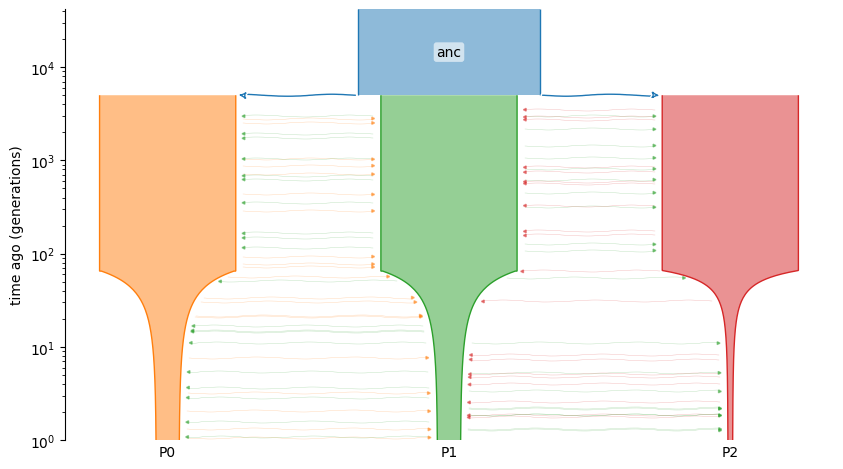

In [16]:
import numpy as np

# Create demography object
demo2 = msp.Demography()

# Add populations
demo2.add_population(initial_size=4000, name="anc")
demo2.add_population(initial_size=500, name="P0", growth_rate=-np.log(3000 / 500)/66)
demo2.add_population(initial_size=500, name="P1", growth_rate=-np.log(3000 / 500)/66)
demo2.add_population(initial_size=100, name="P2", growth_rate=-np.log(3000 / 100)/66)

# Set initial migration rate
demo2.set_symmetric_migration_rate(populations=("P0", "P1"), rate=0.0001)
demo2.set_symmetric_migration_rate(populations=("P1", "P2"), rate=0.0001)

# population size changes near 65–66 generations
demo2.add_population_parameters_change(
    time=65,
    initial_size=3000,  # Bottleneck: reduce to 1000 individuals
    population="P0",
    growth_rate=0
)
demo2.add_population_parameters_change(
    time=65,
    initial_size=3000,  # Bottleneck: reduce to 1000 individuals
    population="P1",
    growth_rate=0
)
demo2.add_population_parameters_change(
    time=66,
    initial_size=3000,  # Bottleneck: reduce to 1000 individuals
    population="P2",
    growth_rate=0
)

# Migration rate change changed to 0.001 AFTER 500 generation (going into the past)
demo2.add_migration_rate_change(
    time=66,
    rate=0.0005, 
    source="P0",
    dest="P1"
)
demo2.add_migration_rate_change(
    time=66,
    rate=0.0005, 
    source="P1",
    dest="P0"
)
demo2.add_migration_rate_change(
    time=66,
    rate=0.0005, 
    source="P1",
    dest="P2"
)
demo2.add_migration_rate_change(
    time=66,
    rate=0.0005, 
    source="P2",
    dest="P1"
)

# THEN add the older events (population split at 1000)
demo2.add_population_split(time=5000, derived=["P0", "P1", "P2"], ancestral="anc")

# Visualize the demography
p = demo2.to_demes()
demesdraw.tubes(p, log_time=True)

## Admixture Example

<Axes: ylabel='time ago (generations)'>

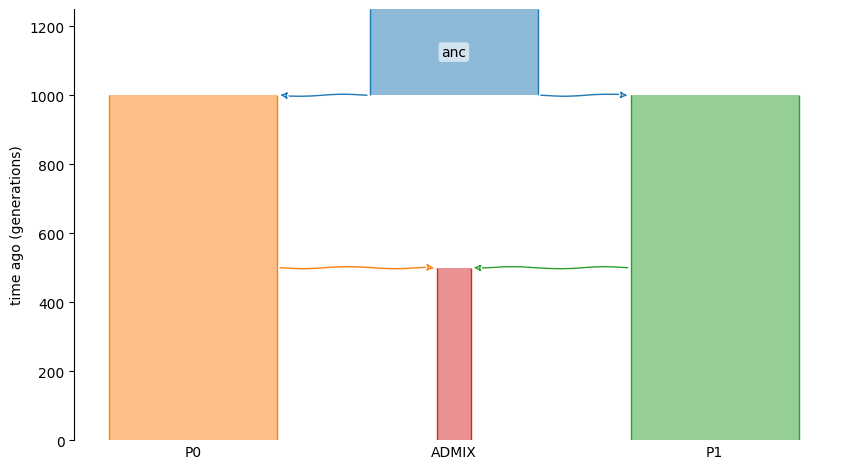

In [17]:
demography = msp.Demography()
demography.add_population(name="P0", initial_size=5000)
demography.add_population(name="P1", initial_size=5000)
demography.add_population(name="ADMIX", initial_size=1000)
demography.add_population(name="anc", initial_size=5000)
demography.add_admixture(
    time=500, derived="ADMIX", ancestral=["P0", "P1"], proportions=[0.4, 0.6])
demography.add_population_split(time=1000, derived=["P0", "P1"], ancestral="anc")

q = demography.to_demes()
demesdraw.tubes(q)